In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings('ignore')

# SCRAPING TWEETS WITH SELENIUM

In [81]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time

# Setting path and opening browser
path = r'C:\\Users\\lukef\\AppData\\Local\\BrowserDriver\\chromedriver.exe'
driver = webdriver.Chrome(executable_path = path)#, options=opts)

# Navigating to old twitter layout extension
site = 'https://chrome.google.com/webstore/detail/old-twitter-layout/jjldkokjmjdnlnifmehbljdafklejeha/related?hl=en'
driver.get(site)
time.sleep(2)

# Building actions class to interact with the website
actions = ActionChains(driver)

# Click download button
actions.move_to_element(driver.find_element_by_class_name('g-c-Hf'))
actions.click().perform()

# Now you must click on download!!!
time.sleep(5)

The following function is modified from a stackexchange answer found here:  
&ensp; https://stackoverflow.com/questions/32391303/how-to-scroll-to-the-end-of-the-page-using-selenium-in-python

In [82]:
def scroll_to_bottom(driver, body):

    old_position = 0
    new_position = None

    while new_position != old_position:
        # Get old scroll position
        old_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))
        # Sleep and Scroll
        body.send_keys(Keys.END)
        time.sleep(1.25)
        driver.execute_script((
                "var scrollingElement = (document.scrollingElement ||"
                " document.body);scrollingElement.scrollTop ="
                " scrollingElement.scrollHeight;"))
        body.send_keys(Keys.END)
        time.sleep(.75)
        body.send_keys(Keys.END)
        # Get new position
        new_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))

Creating list of Twitter search URL's:

In [83]:
feb = ['https://twitter.com/search?l=en&q=instacart%20' + \
        'since%3A2020-02-' + str(day) + \
        '%20until%3A2020-02-' + str(day+1) + \
        '&src=typd' for day in range(1,29)]

feb29 = ['https://twitter.com/search?l=&q=instacart%20' + \
         'since%3A2020-02-29%20until%3A2020-03-01&src=typd']

march = ['https://twitter.com/search?l=en&q=instacart%20' + \
        'since%3A2020-03-' + str(day) + \
        '%20until%3A2020-03-' + str(day+1) + \
        '&src=typd' for day in range(1,30)]

searches = feb + feb29 + march

Now I actually navigate to Twitter and scroll forever to the bottom to load all the tweets containing 'Instacart'.

In [84]:
# tweets = set()
for i in range(len(searches)):
    # Navigate to Twitter with the given search
    driver.get(searches[i])
    time.sleep(2)
    
    # Scroll down to load more tweets
    body = driver.find_element_by_css_selector('body')
    scroll_to_bottom(driver, body)
    scroll_to_bottom(driver, body)
    
     # Get tweets then add them to our tweets set
    twitter_elms = driver.find_elements_by_class_name("content")
    [tweets.add(elm.text) for elm in twitter_elms]
    
    
# Closing browser
driver.close()

# CREATING PANDAS DATAFRAME

In [93]:
df = pd.DataFrame(list(tweets), columns=['raw_text'])
df

,raw_text
0,Ben\n @benkillenit\nMar 26\nMore\nBachelors lo...
1,Madge Weinstein \n🦪\n @bloatedlesbian\nMar 24\...
2,Eva Camille Reign\n @Camille2Reign\nMar 27\nMo...
3,Miroki ★ smashing status quos ★\n @madgingerbr...
4,DebC\n @celedonia_deb\nFeb 14\nMore\nGet groce...
...,...
8237,🌺\nLeslie...Who Pd Kavanaughs Debts \n🧘🏼‍♀️\...
8238,Nathaniel Meyersohn\nVerified account\n @nmeye...
8239,Beverly Cruz\n @Beverly35447345\n7h\n7 hours a...
8240,Supermarket News\n @SN_news\nFeb 8\nMore\nIn a...


# EXTRACTING DATE/TIME
We can see that the time and date is always sandwiched as so:  
&ensp;&ensp;```\n @username\n(TIME/DATE)\n```    
So I'll use a regular expression to capture just that.

In [94]:
regex = r'\n @.*?\n(.*?)\n'
df['date'] = df['raw_text'].str.extract(regex)
df.head()

,raw_text,date
0,Ben\n @benkillenit\nMar 26\nMore\nBachelors lo...,Mar 26
1,Madge Weinstein \n🦪\n @bloatedlesbian\nMar 24\...,Mar 24
2,Eva Camille Reign\n @Camille2Reign\nMar 27\nMo...,Mar 27
3,Miroki ★ smashing status quos ★\n @madgingerbr...,Mar 21
4,DebC\n @celedonia_deb\nFeb 14\nMore\nGet groce...,Feb 14


In [95]:
df[df['date'].isna()]

,raw_text,date
252,@DONNIEJDARKO\nFeb 9\nMore\nan instacart shop...,NaN


# FILLING IN MISSING TIME/DATE VALUE
Looks like one of them didn't have the ```'\n'``` before the username, I'll just fix the one manually.

In [96]:
df.loc[252, 'date'] = 'Feb 9'

# FIXING INCONSISTENT DATE FORMATTING
Posts from today show up as ```4h``` or ```2m```, posts from this year appear as ```Month Day``` and beyond that is ```Day Month Year```. I'll switch everything to ```Day Month Year```.

Thankfully none of the month abbreviations contain lower case m's nor lower case h's so dates containing those lowercase letters can all be safely replaced with today's date (2 March 2020).

In [97]:
df.loc[df[df['date'].str.contains(r'h|m')].index, 'date'] = '29 Mar 2020'

Now, the posts from this year don't contain the year in their date so by filtering for posts that don't have 4 digits in a row (```\d{4}```) we can get all the posts from this year and extract their month and day to rearrange to day month year.

In [98]:
this_year = df[~df['date'].str.contains(r'\d{4}')]
this_year.head()

,raw_text,date
0,Ben\n @benkillenit\nMar 26\nMore\nBachelors lo...,Mar 26
1,Madge Weinstein \n🦪\n @bloatedlesbian\nMar 24\...,Mar 24
2,Eva Camille Reign\n @Camille2Reign\nMar 27\nMo...,Mar 27
3,Miroki ★ smashing status quos ★\n @madgingerbr...,Mar 21
4,DebC\n @celedonia_deb\nFeb 14\nMore\nGet groce...,Feb 14


In [99]:
date_components = this_year['date'].str.extract(r'([A-Za-z]*)\s(\d{1,2})')
fixed_dates = date_components[1] + ' ' + date_components[0] + ' 2020'

df.loc[fixed_dates.index, 'date'] = fixed_dates
df

,raw_text,date
0,Ben\n @benkillenit\nMar 26\nMore\nBachelors lo...,26 Mar 2020
1,Madge Weinstein \n🦪\n @bloatedlesbian\nMar 24\...,24 Mar 2020
2,Eva Camille Reign\n @Camille2Reign\nMar 27\nMo...,27 Mar 2020
3,Miroki ★ smashing status quos ★\n @madgingerbr...,21 Mar 2020
4,DebC\n @celedonia_deb\nFeb 14\nMore\nGet groce...,14 Feb 2020
...,...,...
8237,🌺\nLeslie...Who Pd Kavanaughs Debts \n🧘🏼‍♀️\...,19 Mar 2020
8238,Nathaniel Meyersohn\nVerified account\n @nmeye...,6 Mar 2020
8239,Beverly Cruz\n @Beverly35447345\n7h\n7 hours a...,29 Mar 2020
8240,Supermarket News\n @SN_news\nFeb 8\nMore\nIn a...,8 Feb 2020


In [100]:
df['date'] = pd.to_datetime(df['date'])

# CREATING DATAFRAME OF TOTAL TWEETS OF EACH DAY
Saving it in the dataframe ```twt_cnt``` short for "tweet count".

In [196]:
twt_cnt = df.groupby('date').count()
twt_cnt.rename(columns = {'raw_text':'total_tweets'}, inplace = True)
twt_cnt.head()

,total_tweets
date,
2020-01-31,18
2020-02-01,116
2020-02-02,78
2020-02-03,44
2020-02-04,96


## READING IN NEW YORK TIME COVID-19 DATA

In [197]:
file = r'C:\Users\lukef\Desktop\COVID_NYT\covid-19-data\us-states.csv'
cov = pd.read_csv(file)
cov['date'] = pd.to_datetime(cov['date'])

cov.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


## CREATING DATAFRAME FOR TOTAL COVID-19 NUMBERS FOR EACH DAY

In [135]:
sums = cov.groupby('date').sum()

## GRAPHING TWEETS VS COVID-19 CASES

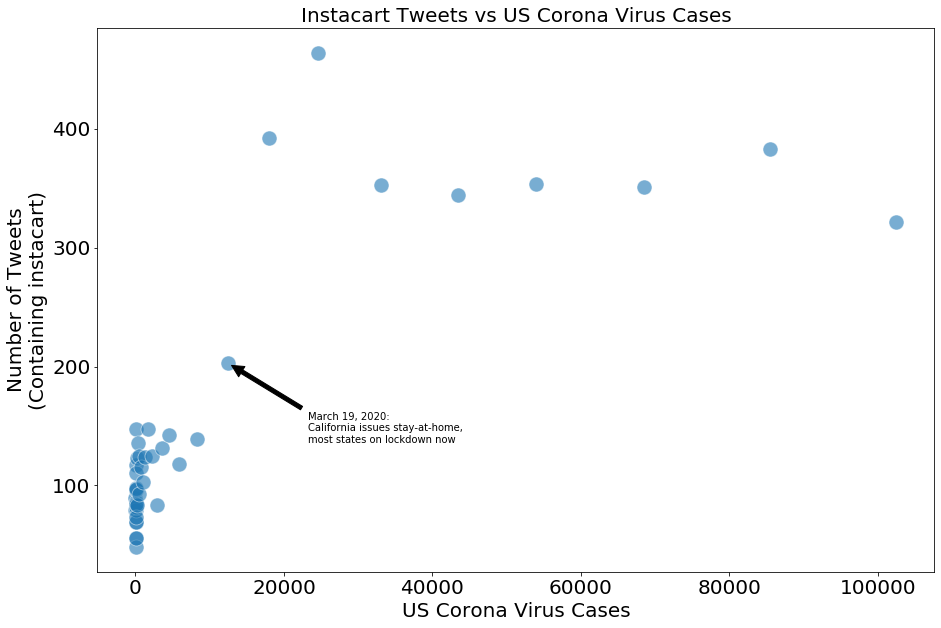

In [202]:
# Setting up the figure and axes
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# Creating the regplot
sns.scatterplot(x = sums.loc['2020-02-15':'2020-03-27']['cases'], 
                y = twt_cnt.loc['2020-02-15':'2020-03-27']['total_tweets'],
                s = 225,
                alpha = 0.6,
                ax = ax);

# Labeling
ax.set_title('Instacart Tweets vs US Corona Virus Cases')
ax.set_ylabel('Number of Tweets\n(Containing instacart)')
ax.set_xlabel('US Corona Virus Cases')

# Annotating point before large jump
ax.annotate(s = 'March 19, 2020:\nCalifornia issues stay-at-home,\nmost states on lockdown now',
            xy = (sums.loc['2020-03-19', 'cases'],
                  twt_cnt.loc['2020-03-19', 'total_tweets']),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xytext=(80, -80), 
            textcoords='offset points')


# Increasing size of text and ticks
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20);

Given the exponential growth in cases it is hard to get much information from this graph. To make it more legible I'll take a logarithm of the x-axis (corona virus cases) below.

# GRAPHING TWEETS VS LOG CASES

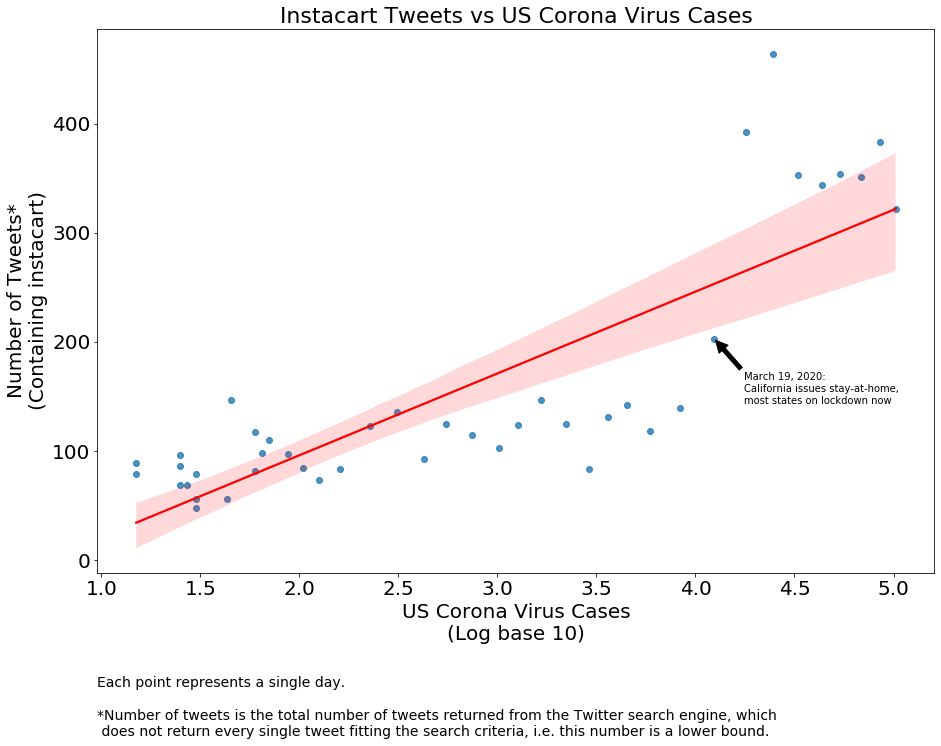

In [280]:
# Setting up the figure and axes
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# Creating the regplot
reg = sns.regplot(x = np.log10(sums.loc['2020-02-15':'2020-03-27']['cases']), 
                  y = twt_cnt.loc['2020-02-15':'2020-03-27']['total_tweets'],
                  ax = ax,
                  line_kws={'color': 'red'});
    
# Labeling
ax.set_title('Instacart Tweets vs US Corona Virus Cases', fontdict={'fontsize':22})
ax.set_ylabel('Number of Tweets*\n(Containing instacart)')
ax.set_xlabel('US Corona Virus Cases\n(Log base 10)')

# Annotating point before large jump
ax.annotate(s = 'March 19, 2020:\nCalifornia issues stay-at-home,\nmost states on lockdown now',
            xy = (np.log10(sums.loc['2020-03-19', 'cases']),
                  twt_cnt.loc['2020-03-19', 'total_tweets']),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xytext=(30, -65), 
            textcoords='offset points')

# Adding note
note = 'Each point represents a single day.\n\n*Number of tweets is the total ' + \
       'number of tweets returned from the Twitter search engine, which\n does not ' + \
       'return every single tweet fitting the search criteria, i.e. this number is a lower bound.'
ax.text(0.0,-.30, note, size=14, ha='left', transform=ax.transAxes)

# Increasing size of text and ticks
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20);
    
# Saving the graph
fig.savefig('Tweets vs COVID-19 Cases.png', dpi = fig.dpi, bbox_inches = "tight");

Now we can get a better visual on how the tweets have been growing with Corona Virus cases. Annoyingly, however, Seaborn does not return the value of their regression line directly but it can be computed using:  
```Python
x0, x1 = reg.get_lines()[0].get_xdata()[0], reg.get_lines()[0].get_xdata()[1]
y0, y1 = reg.get_lines()[0].get_ydata()[0], reg.get_lines()[0].get_ydata()[1]
m = (y1 - y0) / (x1 - x0); b = y0 - (m * x0)```  
From which we get the following equation:  
&ensp;&ensp;&ensp;&ensp;&ensp;$y = 75\cdot\log_{10}(x) - 54$  
Hence every time the US Corona virus cases increases tenfold we see approximately 75 more tweets. Let's do an actual regression to see the R-squared values and double check the line we found above.

# OLS REGRESSION

In [249]:
import statsmodels.api as sm

# Adding a constant (since we later take log10 the constant is made to be 10)
sums['const'] = 10

reg = sm.OLS(endog = twt_cnt.loc['2020-02-15':'2020-03-27']['total_tweets'], 
             exog = np.log10(sums.loc['2020-02-15':'2020-03-27'][['cases','const']]),
             hasconst = False)
results = reg.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_tweets   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              168.3
Date:                Mon, 30 Mar 2020   Prob (F-statistic):                    3.34e-20
Time:                        13:27:36   Log-Likelihood:                         -232.81
No. Observations:                  42   AIC:                                      469.6
Df Residuals:                      40   BIC:                                      473.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We see that these results indeed agree with the seaborn results.  

Suppose now we want to know how many tweets to expect every time the number of cases double. While we could run the above regression with ```log2``` instead, let's figure it out based on what we have above.

\begin{align}
Y &= 75 \cdot \log_{10}(X) - 54 \\ \\
\Rightarrow Y_{double} &= 75 \cdot \log_{10}(2\cdot X) - 54 \\
 &= 75 \cdot \big(\log_{10}(2) + \log_{10} (X)\big) - 54 \\
 &= 75 \cdot \log_{10}(X) - 54 + 75\cdot\log_{10}(2) \\
 &= Y + \log_{10}(2) \\ \\
\Rightarrow Y_{double} - Y &=  75\cdot \log_{10}(2) \\ 
 &= 22.57794
\end{align}

Therefore everyone time the corona virus cases double we expect to see about 23 new tweets containing instacart! Let's check our work by running the regression with ```log2```.

In [250]:
sums['const'] = 2

reg = sm.OLS(endog = twt_cnt.loc['2020-02-15':'2020-03-27']['total_tweets'], 
             exog = np.log2(sums.loc['2020-02-15':'2020-03-27'][['cases','const']]),
             hasconst = False)
results = reg.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_tweets   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              168.3
Date:                Mon, 30 Mar 2020   Prob (F-statistic):                    3.34e-20
Time:                        13:40:30   Log-Likelihood:                         -232.81
No. Observations:                  42   AIC:                                      469.6
Df Residuals:                      40   BIC:                                      473.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Voilà! The numbers agree.